Code References:

https://nextjournal.com/gkoehler/pytorch-mnist
https://www.analyticsvidhya.com/blog/2021/05/a-complete-hands-on-guide-to-train-your-neural-network-model-on-google-colab-gpu/
https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms

In [2]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(p=0.5)
        
        self.conv1 = nn.Conv2d(1, 64, 3, 1, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv3 = nn.Conv2d(128, 256, 3, 1, 1)
        self.conv4 = nn.Conv2d(256, 256, 3, 1, 1)
        self.conv5 = nn.Conv2d(256, 512, 3, 1, 1)
        self.conv6 = nn.Conv2d(512, 512, 3, 1, 1)
        self.conv7 = nn.Conv2d(512, 512, 3, 1, 1)
        self.conv8 = nn.Conv2d(512, 512, 3, 1, 1)
        
        self.bnorm1 = nn.BatchNorm2d(64)
        self.bnorm2 = nn.BatchNorm2d(128)
        self.bnorm3 = nn.BatchNorm2d(256)
        self.bnorm4 = nn.BatchNorm2d(256)
        self.bnorm5 = nn.BatchNorm2d(512)
        self.bnorm6 = nn.BatchNorm2d(512)
        self.bnorm7 = nn.BatchNorm2d(512)
        self.bnorm8 = nn.BatchNorm2d(512)
        
        self.fc1 = nn.Linear(512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(F.relu(self.bnorm1(x)))
        
        x = self.conv2(x)
        x = self.pool(F.relu(self.bnorm2(x)))
        
        x = self.conv3(x)
        x = F.relu(self.bnorm3(x))
        
        x = self.conv4(x)
        x = self.pool(F.relu(self.bnorm4(x)))
        
        x = self.conv5(x)
        x = F.relu(self.bnorm5(x))
        
        x = self.conv6(x)
        x = self.pool(F.relu(self.bnorm6(x)))
        
        x = self.conv7(x)
        x = F.relu(self.bnorm7(x))
        
        x = self.conv8(x)
        x = self.pool(F.relu(self.bnorm8(x)))

        x = torch.flatten(x, 1)
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
        

<h2>Training the neural net<h2/>

In [62]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [63]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [64]:
class DeviceDataLoader():
    def __init__(self,dl,device):
      self.dl = dl
      self.device = device
    def __iter__(self):
      for b in self.dl:
        yield to_device(b, self.device)
    def __len__(self):
      return len(self.dl)

In [65]:
device = get_default_device()
trainset = tv.datasets.MNIST(
    root='./MNISTdataset', 
    train=True, 
    download=True, 
    transform=transforms.Compose(
        [transforms.Resize(32), transforms.ToTensor()]
    ),
)
vertifliptrainset = tv.datasets.MNIST(
    root='./MNISTdataset', 
    train=True, 
    download=True, 
    transform=transforms.Compose(
        [transforms.Resize(32), transforms.RandomVerticalFlip(p=1), transforms.ToTensor()]
    ),
)
horifliptrainset = tv.datasets.MNIST(
    root='./MNISTdataset', 
    train=True, 
    download=True, 
    transform=transforms.Compose(
        [transforms.Resize(32), transforms.RandomHorizontalFlip(p=1), transforms.ToTensor()]
    ),
)
gaussiannoisetrainset = tv.datasets.MNIST(
    root='./MNISTdataset', 
    train=True, 
    download=True, 
    transform=transforms.Compose(
        [transforms.Resize(32), transforms.ToTensor(), transforms.Lambda(lambda x : x + 0.1*torch.randn_like(x))]
    ),
)
testset = tv.datasets.MNIST(
    root='./MNISTdataset', 
    train=False, 
    download=True, 
    transform=transforms.Compose(
        [transforms.Resize(32), transforms.ToTensor(),]
    ),
)
vertifliptestset = tv.datasets.MNIST(
    root='./MNISTdataset', 
    train=False, 
    download=True, 
    transform=transforms.Compose(
        [transforms.Resize(32), transforms.RandomVerticalFlip(p=1), transforms.ToTensor()]
    ),
)
horifliptestset = tv.datasets.MNIST(
    root='./MNISTdataset', 
    train=False, 
    download=True, 
    transform=transforms.Compose(
        [transforms.Resize(32), transforms.RandomHorizontalFlip(p=1), transforms.ToTensor()]
    ),
)
gaussiannoisetestset = tv.datasets.MNIST(
    root='./MNISTdataset', 
    train=False, 
    download=True, 
    transform=transforms.Compose(
        [transforms.Resize(32), transforms.ToTensor(), transforms.Lambda(lambda x : x + 0.1*torch.randn_like(x))]
    ),
)
augmentedtrainset = torch.utils.data.ConcatDataset([trainset,vertifliptrainset,horifliptrainset,gaussiannoisetrainset])
trainloader = DeviceDataLoader(torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False), device)
testloader = DeviceDataLoader(torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False), device)
vertifliptestloader = DeviceDataLoader(torch.utils.data.DataLoader(vertifliptestset, batch_size=1024, shuffle=False), device)
horifliptestloader = DeviceDataLoader(torch.utils.data.DataLoader(horifliptestset, batch_size=1024, shuffle=False), device)
gaussiannoisetestloader = DeviceDataLoader(torch.utils.data.DataLoader(gaussiannoisetestset, batch_size=1024, shuffle=False), device)
augmentedtrainloader = DeviceDataLoader(torch.utils.data.DataLoader(augmentedtrainset, batch_size=64, shuffle=True), device)
criterion = nn.CrossEntropyLoss()

In [66]:
def gaussiannoisetestloader(variance):
  return DeviceDataLoader(torch.utils.data.DataLoader(tv.datasets.MNIST(
                                                        root='./MNISTdataset', 
                                                        train=False, 
                                                        download=True, 
                                                        transform=transforms.Compose(
                                                            [transforms.Resize(32), transforms.ToTensor(), transforms.Lambda(lambda x : x + variance*torch.randn_like(x))]
                                                        ),
                                                    ), batch_size=1024, shuffle=False), device)

In [7]:
net = Net()
net.cuda()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
for epoch in range(1,6):
  net.train()
  for i, (inputs, label) in enumerate(trainloader):
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()
    loss.detach()
    if i % 20 == 19:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, i * len(inputs), len(trainloader.dl.dataset),
        100. * i / len(trainloader), loss.item()))
  torch.save(net.state_dict(), "model"+str(epoch)+".pth")

Testing the network

In [15]:
def test(path, loader, mode):
  net.load_state_dict(torch.load(path))
  net.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for inputs, label in loader:
      outputs = net(inputs)
      test_loss += criterion(outputs, label)
      pred = outputs.data.max(1, keepdim=True)[1]
      correct += pred.eq(label.data.view_as(pred)).sum()
    test_loss /= len(loader.dl.dataset)
    print('\n{} set: Avg. loss: {:.8f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      mode, test_loss, correct, len(loader.dl.dataset),
      100. * correct / len(loader.dl.dataset)))

In [16]:
for i in range(1,6):
  test("model"+str(i)+".pth", testloader, "test")
  test("model"+str(i)+".pth", trainloader, "train")


test set: Avg. loss: 0.00004005, Accuracy: 9871/10000 (99%)


train set: Avg. loss: 0.00059573, Accuracy: 59297/60000 (99%)


test set: Avg. loss: 0.00003092, Accuracy: 9918/10000 (99%)


train set: Avg. loss: 0.00036500, Accuracy: 59598/60000 (99%)


test set: Avg. loss: 0.00003501, Accuracy: 9892/10000 (99%)


train set: Avg. loss: 0.00040383, Accuracy: 59567/60000 (99%)


test set: Avg. loss: 0.00002613, Accuracy: 9932/10000 (99%)


train set: Avg. loss: 0.00018326, Accuracy: 59790/60000 (100%)


test set: Avg. loss: 0.00002532, Accuracy: 9936/10000 (99%)


train set: Avg. loss: 0.00012786, Accuracy: 59850/60000 (100%)



In [18]:
import numpy as np
epoch = np.linspace(1,5,5)
testloss = [0.00004005,0.00003092,0.00003501,0.00002613,0.00002532]
testaccuracy = [9871/10000,9918/10000,9892/10000,9932/10000,9936/10000]
trainloss = [0.00059573,0.00036500,0.00040383,0.00018326,0.00012786]
trainaccuracy = [59297/60000,59598/60000,59567/60000,59790/60000,59850/60000]

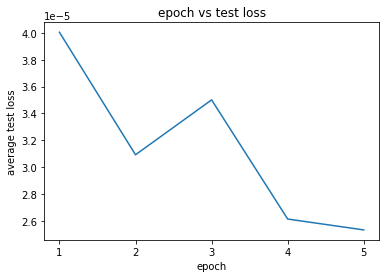

In [20]:
plt.plot(epoch, testloss)
plt.xlabel("epoch")
plt.ylabel("average test loss")
plt.xticks(epoch)
plt.title("epoch vs test loss")
plt.savefig("epochVsTestloss.pdf")

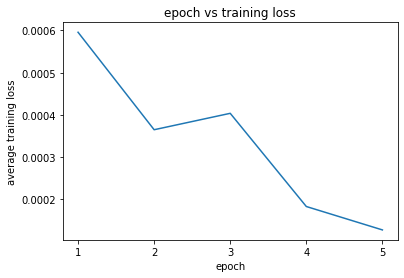

In [21]:
plt.plot(epoch, trainloss)
plt.xlabel("epoch")
plt.ylabel("average training loss")
plt.xticks(epoch)
plt.title("epoch vs training loss")
plt.savefig("epochVsTrainloss.pdf")

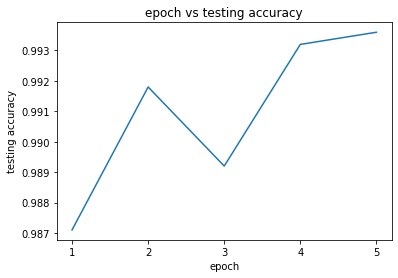

In [22]:
plt.plot(epoch, testaccuracy)
plt.xlabel("epoch")
plt.ylabel("testing accuracy")
plt.xticks(epoch)
plt.title("epoch vs testing accuracy")
plt.savefig("epochVstestaccuracy.pdf")

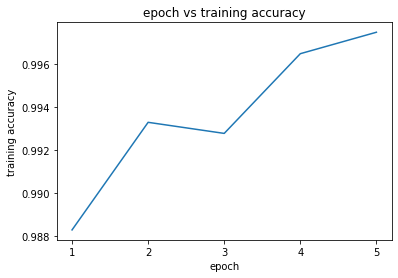

In [23]:
plt.plot(epoch, trainaccuracy)
plt.xlabel("epoch")
plt.ylabel("training accuracy")
plt.xticks(epoch)
plt.title("epoch vs training accuracy")
plt.savefig("epochVstrainaccuracy.pdf")

In [37]:
test("model5.pth", vertifliptestloader, "vertical")
test("model5.pth", horifliptestloader, "horizontal")


vertical set: Avg. loss: 0.00422418, Accuracy: 4357/10000 (44%)


horizontal set: Avg. loss: 0.00417148, Accuracy: 4009/10000 (40%)



In [38]:
flipacc = [4357/10000, 4009/10000]

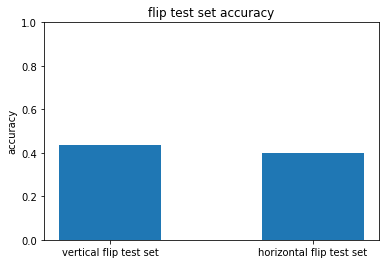

In [58]:
plt.bar([1,2], flipacc, 0.5, tick_label=["vertical flip test set","horizontal flip test set"])
plt.ylabel("accuracy")
plt.ylim(0,1)
plt.title("flip test set accuracy")
plt.savefig("Flips.pdf")

In [59]:
for variance in [0.01, 0.1, 1]:
  test("model5.pth", gaussiannoisetestloader(variance), "gaussian")

TypeError: ignored

In [47]:
gaussianacc = [9937/10000, 9853/10000, 975/10000]

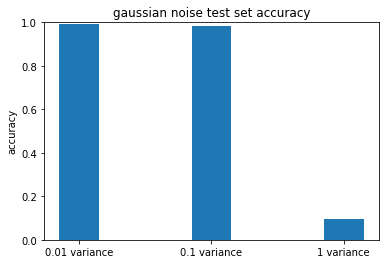

In [60]:
plt.bar([1,2,3], gaussianacc, 0.3, tick_label=["0.01 variance","0.1 variance","1 variance"])
plt.ylabel("accuracy")
plt.ylim(0,1)
plt.title("gaussian noise test set accuracy")
plt.savefig("Gaussian.pdf")

In [54]:
augnet = Net()
augnet.cuda()
augoptimizer = optim.SGD(augnet.parameters(), lr=0.01, momentum=0.9)

In [72]:
for epoch in range(1,6):
  augnet.train()
  for i, (inputs, label) in enumerate(augmentedtrainloader):
    augoptimizer.zero_grad()
    outputs = augnet(inputs)
    loss = criterion(outputs, label)
    loss.backward()
    augoptimizer.step()
    loss.detach()
    if i % 20 == 19:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, i * len(inputs), len(augmentedtrainloader.dl.dataset),
        100. * i / len(augmentedtrainloader), loss.item()))
torch.save(augnet.state_dict(), "augmentedmodel.pth")

Train Epoch: 1 [1216/240000 (1%)]	Loss: 0.531216
Train Epoch: 1 [2496/240000 (1%)]	Loss: 0.414602
Train Epoch: 1 [3776/240000 (2%)]	Loss: 0.458297
Train Epoch: 1 [5056/240000 (2%)]	Loss: 0.269484
Train Epoch: 1 [6336/240000 (3%)]	Loss: 0.115832
Train Epoch: 1 [7616/240000 (3%)]	Loss: 0.195161
Train Epoch: 1 [8896/240000 (4%)]	Loss: 0.092784
Train Epoch: 1 [10176/240000 (4%)]	Loss: 0.288676
Train Epoch: 1 [11456/240000 (5%)]	Loss: 0.254367
Train Epoch: 1 [12736/240000 (5%)]	Loss: 0.224454
Train Epoch: 1 [14016/240000 (6%)]	Loss: 0.108996
Train Epoch: 1 [15296/240000 (6%)]	Loss: 0.128654
Train Epoch: 1 [16576/240000 (7%)]	Loss: 0.194555
Train Epoch: 1 [17856/240000 (7%)]	Loss: 0.183955
Train Epoch: 1 [19136/240000 (8%)]	Loss: 0.121594
Train Epoch: 1 [20416/240000 (9%)]	Loss: 0.110184
Train Epoch: 1 [21696/240000 (9%)]	Loss: 0.035254
Train Epoch: 1 [22976/240000 (10%)]	Loss: 0.031443
Train Epoch: 1 [24256/240000 (10%)]	Loss: 0.341987
Train Epoch: 1 [25536/240000 (11%)]	Loss: 0.086877
Trai

In [73]:
test("augmentedmodel.pth", vertifliptestloader, "vertical")
test("augmentedmodel.pth", horifliptestloader, "horizontal")
for variance in [0.01, 0.1, 1]:
  test("augmentedmodel.pth", gaussiannoisetestloader(variance), "gaussian")


vertical set: Avg. loss: 0.00004024, Accuracy: 9886/10000 (99%)


horizontal set: Avg. loss: 0.00003293, Accuracy: 9902/10000 (99%)


gaussian set: Avg. loss: 0.00004770, Accuracy: 9870/10000 (99%)


gaussian set: Avg. loss: 0.00003666, Accuracy: 9904/10000 (99%)


gaussian set: Avg. loss: 0.00394112, Accuracy: 2139/10000 (21%)



In [77]:
augmentedflipacc = [9886/10000,9902/10000]
augmentedgaussianacc = [9870/10000,9904/10000,2139/10000]

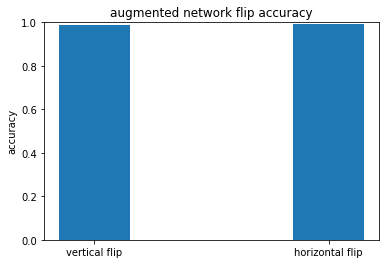

In [80]:
plt.bar([1,2], augmentedflipacc, 0.3, tick_label=["vertical flip","horizontal flip"])
plt.ylabel("accuracy")
plt.ylim(0,1)
plt.title("augmented network flip accuracy")
plt.savefig("augmentedf.pdf")

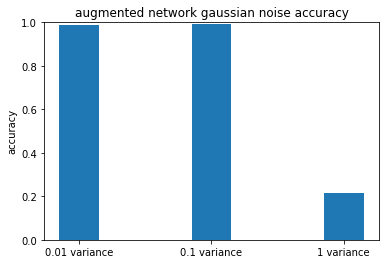

In [81]:
plt.bar([1,2,3], augmentedgaussianacc, 0.3, tick_label=["0.01 variance","0.1 variance","1 variance"])
plt.ylabel("accuracy")
plt.ylim(0,1)
plt.title("augmented network gaussian noise accuracy")
plt.savefig("augmentedg.pdf")